# Using bpnet-lite to traina CTCF profile model

In [2]:
import torch
import seqdata as sd
import seqpro as sp
from pathlib import Path
from bpnetlite import BPNet
from eugene.dataload._augment import RandomJitter

# Define paths
data_dir = Path("/cellar/shared/carterlab/data/ml4gland/ENCSR000EGM/data")
fasta = Path("/cellar/users/aklie/data/ml4gland/use_cases/avsec21/reference/hg38.fa")
peaks = data_dir / "peaks.bed"
signals = [data_dir / "plus.bw", data_dir / "minus.bw"]
controls = [data_dir / "control_plus.bw", data_dir / "control_minus.bw"]
control_samples = ['plus', 'minus']
bigwigs = signals + controls
sample_names = ['signal+', 'signal-', 'control+', 'control-']
out = '/cellar/users/dlaub/projects/ML4GLand/use_cases/avsec21/avsec21.zarr'

# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

# Load data

In [2]:
# sdata = sd.from_region_files(
#     sd.GenomeFASTA(
#         'seq',
#         fasta,
#         batch_size=2048,
#         n_threads=4,
#     ),
#     sd.BigWig(
#         'cov',
#         bigwigs,
#         sample_names,
#         batch_size=2048,
#         n_jobs=4,
#         threads_per_job=2,
#     ),
#     path=out,
#     fixed_length=2114,
#     bed=peaks,
#     overwrite=True,
#     max_jitter=128
# )

100%|██████████| 57244/57244 [01:20<00:00, 713.19it/s] 

In [3]:
sdata = sd.open_zarr(out)
# split cov into control and signal
sdata['control'] = (
    sdata.cov.sel(cov_sample=['control+', 'control-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata['signal'] = (
    sdata.cov.sel(cov_sample=['signal+', 'signal-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata = sdata.drop_vars(['cov', 'cov_sample'])
sdata

<xarray.Dataset>
Dimensions:     (_sequence: 57244, _length: 2370, cov_strand: 2)
Coordinates:
  * cov_strand  (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    blockCount  (_sequence) uint64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chrom       (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    chromEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chromStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    itemRgb     (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    ...          ...
    seq         (_sequence, _length) |S1 dask.array<chunksize=(2048, 2370), meta=np.ndarray>
    strand      (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    thickEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    thickStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    control     (_sequence, cov_strand, _length) uint16 dask.array<chunksize=(2048, 1, 2370), meta=np.ndarray>
    signal      (_sequence, cov_strand, _length) uint16 dask.array<chunksize=(2048, 1, 2370), meta=np.ndarray>
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [12]:
sdata[['seq', 'control', 'signal']].load()

<xarray.Dataset>
Dimensions:     (_sequence: 57244, _length: 2370, cov_strand: 2)
Coordinates:
  * cov_strand  (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables:
    seq         (_sequence, _length) |S1 b'a' b't' b'c' b'a' ... b'C' b'C' b'C'
    control     (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
    signal      (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [38]:
sdata

<xarray.Dataset>
Dimensions:     (_sequence: 57244, _length: 2370, cov_strand: 2)
Coordinates:
  * cov_strand  (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    blockCount  (_sequence) uint64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chrom       (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    chromEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chromStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    itemRgb     (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    ...          ...
    seq         (_sequence, _length) |S1 b'a' b't' b'c' b'a' ... b'C' b'C' b'C'
    strand      (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    thickEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    thickStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    control     (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
    signal      (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [39]:
from eugene import preprocess as pp

In [41]:
pp.train_test_split_sdata(sdata, chroms=valid_chroms)

In [43]:
sdata_train = sdata.sel(_sequence=(sdata["train_val"]==True).compute())
sdata_valid = sdata.sel(_sequence=(sdata["train_val"]==False).compute())

In [54]:
(2114-1000) // 2

557

In [36]:
def seq_trans(x):
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    jitter = RandomJitter(128, -1)
    x = jitter(x)
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 128:-128]
    return torch.as_tensor(x.astype('f4'))

def cov_trans(x):
    x = x[..., 128+557:-128-557]
    return torch.as_tensor(x.astype('f4'))

dl = sd.get_torch_dataloader(
    sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=8,
    transforms={
        'seq': seq_trans,
        'control': ctl_trans,
        'signal': cov_trans,
    },
    return_tuples=True
)

In [60]:
X_valid = seq_trans(sdata_valid["seq"].values)
X_ctl_valid = ctl_trans(sdata_valid["control"].values)
y_valid = cov_trans(sdata_valid["signal"].values)

In [61]:
X_valid.shape, X_ctl_valid.shape, y_valid.shape

(torch.Size([7051, 4, 2114]),
 torch.Size([7051, 2, 2114]),
 torch.Size([7051, 2, 1000]))

In [62]:
batch = next(iter(dl))

In [63]:
[x.shape for x in batch]

[torch.Size([8, 4, 2114]), torch.Size([8, 2, 2114]), torch.Size([8, 2, 1000])]

# Train a model

In [64]:
# Create the model, we need 2 channels for the control tracks, 2 channels for the signal tracks, and to trim to 1000 bp of input
model = BPNet(n_outputs=2, n_control_tracks=2, trimming=(2114 - 1000) // 2)

In [65]:
# Quickly define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
batch = next(iter(dl))
pred_ctl = model.forward(*batch[:2])

In [67]:
pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([8, 2, 1000]), torch.Size([8, 1]))

In [68]:
model.to("cuda")

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

In [69]:
# Use the models fit_generator method to train the model
res = model.fit(
    dl,
    optimizer,
    X_valid=X_valid,
	X_ctl_valid=X_ctl_valid,
    y_valid=y_valid
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	0	0.3912	2.2493	332.6915	23.515	624.5649	0.016558437	0.17774013	18.7346	True
0	100	47.0326	1.3451	205.3518	0.493	345.6784	0.059370257	0.11144464	1.0432	True
0	200	43.6553	1.3504	179.3701	1.1216	343.743	0.06674333	0.26455897	2.9741	True
0	300	39.6917	1.3293	238.1074	0.0818	341.222	0.08329837	0.23577113	0.6199	True
0	400	34.0728	1.3388	285.4426	0.1268	344.3551	0.09164733	0.31412685	0.6299	False
0	500	26.617	1.3547	253.0327	0.0715	338.8847	0.10050652	0.2504643	0.6526	True
0	600	24.6519	1.3524	239.6167	0.1382	342.5997	0.07527057	0.16028741	0.6987	False
0	700	26.7083	1.3518	246.1688	0.3118	339.71	0.093269765	0.1947302	1.1578	False
0	800	27.885	1.3471	306.2147	0.3144	336.3614	0.113641046	0.32973406	0.5748	True
0	900	32.5817	1.3443	293.274	0.0721	334.3787	0.12468848	0.31532997	0.5797	True
0	1000	29.9661	1.354	282.2733	

# Interpret the trained model

In [632]:
from bpnetlite.attributions import calculate_attributions

In [634]:
# Run if you haven't already
X_valid, y_valid, X_ctl_valid = extract_peaks(peaks, seqs, signals, controls, chroms=valid_chroms, max_jitter=0)
X_valid.shape, y_valid.shape, X_ctl_valid.shape

(torch.Size([7051, 4, 2114]),
 torch.Size([7051, 2, 1000]),
 torch.Size([7051, 2, 2114]))

In [636]:
models_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/avsec21/models"

In [644]:
pretrained_model = torch.load(os.path.join(models_dir, "bpnet.64.8.torch")).cuda()
X = X_valid[:32].cuda()
X_ctl = (torch.zeros(X.shape[0], 2, X.shape[-1]).cuda(), )
X.shape, X_ctl[0].shape

(torch.Size([32, 4, 2114]), torch.Size([32, 2, 2114]))

In [652]:
example_outs = pretrained_model(X, X_ctl[0])
example_outs[0].shape, example_outs[1].shape

(torch.Size([32, 2, 1000]), torch.Size([32, 1]))

: 

In [650]:
X_attr = calculate_attributions(
    pretrained_model,
    X.cpu(),
    X_ctl
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [ ]:
import pandas as pd
import logomaker
def plot_attributions(X_attr, ax):
	"""Plot the attributions using logomaker.
	Takes in a matrix of attributions and plots the attribution-weighted
	sequence using logomaker. This is a convenience function.
	Parameters
	----------
	X_attr: torch.tensor, shape=(4, -1)
		A tensor of the attributions. Can be either the hypothetical
		attributions, where the entire matrix has values, or the projected
		attributions, where only the actual bases have their attributions
		stored, i.e., 3 values per column are zero.
	"""

	df = pd.DataFrame(X_attr.T, columns=['A', 'C', 'G', 'T'])
	df.index.name = 'pos'
	logo = logomaker.Logo(df, ax=ax)
	logo.style_spines(visible=False)
	return 

                 A    C             G    T
pos                                       
0     0.000000e+00  0.0  0.000000e+00  0.0
1    -2.066440e-13  0.0 -0.000000e+00  0.0
2     0.000000e+00  0.0  1.383642e-12  0.0
3     1.326429e-12 -0.0 -0.000000e+00 -0.0
4    -1.127276e-12  0.0  0.000000e+00  0.0
...            ...  ...           ...  ...
2109  1.179696e-12  0.0  0.000000e+00 -0.0
2110 -9.192583e-12  0.0 -0.000000e+00  0.0
2111 -5.749478e-12  0.0  0.000000e+00  0.0
2112  0.000000e+00  0.0  0.000000e+00  0.0
2113  0.000000e+00  0.0  0.000000e+00  0.0

[2114 rows x 4 columns]


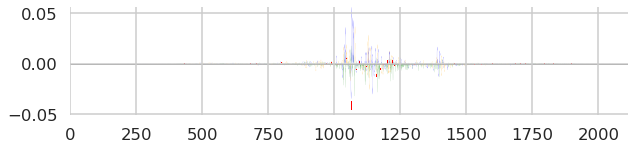

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plot_attributions(X_attr[0].detach().cpu().numpy(), ax)